# Vehicle Detection Project
---
 The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

## Data reparation

In [2]:
# Include used module and function
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from lesson_functions import *
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    print(data_dict["n_cars"])
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    print(data_dict["n_notcars"])
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = cv2.imread(car_list[0])
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict

In [3]:
notcar_path = ['./training_samples/non-vehicles/GTI/*.png',
            './training_samples/non-vehicles/Extras/*.png',]
car_path = ['./training_samples/vehicles/GTI_Far/*.png',
           './training_samples/vehicles/GTI_Left/*.png',
           './training_samples/vehicles/GTI_MiddleClose/*.png',
           './training_samples/vehicles/GTI_Right/*.png',
            './training_samples/vehicles/KITTI_extracted/*.png',]

cars = []
for path in car_path:
    cars.extend(glob.glob(path))

notcars = []
for path in notcar_path:
    notcars.extend(glob.glob(path))

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

8792
8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


## Histogram of Oriented Gradients (HOG)
---
### 1\. Explain how (and identify where in your code) you extracted HOG features from the training images.
I select one image from each of the car and non-car data set to demonstrate the difference in HOG features.
Here are the example:

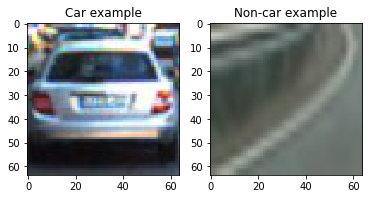

In [4]:
car_image = mpimg.imread('./output_images/40.jpeg')
notcar_image = mpimg.imread('./output_images//image0186.jpeg')

plt.subplot(121)
plt.imshow(car_image)
plt.title('Car example')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Non-car example')

The `get_hog_features()` in `lesson_functions.py` (line 6 through line 23) is parameter wrapper to `skimage.hog()`.

I then explored different color spaces and different `skimage.hog()` parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like. An example displaying hog feature with repect to each channel for the two images is showing below:


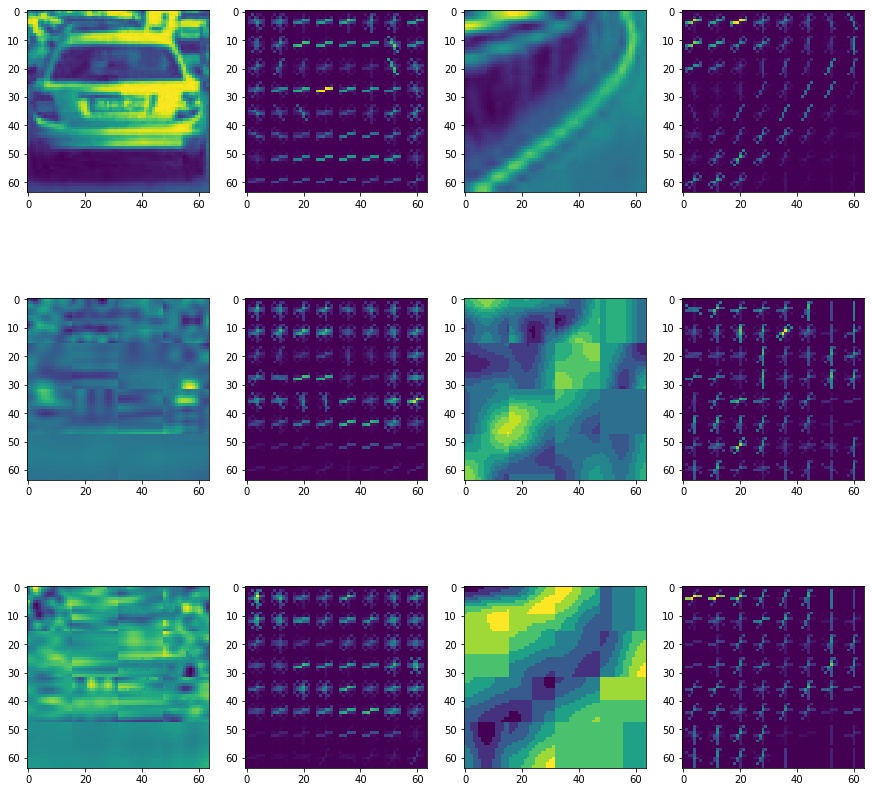

In [5]:
car_cs_img = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_cs_img = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

row,col = 3,4
f, ax = plt.subplots(row, col, figsize=(15,15))
for r in range(row):
    plt.subplot(row, col, 1 + r * col)
    plt.imshow(car_cs_img[:,:,r])
    
    plt.subplot(row, col, 2 + r * col)
    features,vis_img = get_hog_features(car_cs_img[:,:,r], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.imshow(vis_img)
    
    plt.subplot(row, col, 3 + r * col)
    plt.imshow(notcar_cs_img[:,:,r])
    
    plt.subplot(row, col, 4 + r * col)
    features,vis_img = get_hog_features(notcar_cs_img[:,:,r], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.imshow(vis_img)

### 2\. Explain how you settled on your final choice of HOG parameters.
I tried various combinations of parameters on my SVM. Consider the example using YCbCr color spaces above, it is obvious that this color space is better for object shape detection. The HOG features are apparent for the two images. The SVM accuracy below shows higher accuracy (99.1% v.s. 98.8%) compared to other color spaces.
### 3\. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
By utilizing `extract_features()` in `lesson_functions.py` (line 46 through line 94), I use the following parameters for my HOG features:

* color space: YCrCb
* orientation: 9
* pix per cell: 8
* cell_per_block: 2
* HOG channel: ALL

In addition, the spatial and color features are also used:

* spatial size: 32
* color histbin: 64

The three features are collected and are normalized by using `StandardScaler()`. Scaled features are split and fed into a linear SVC with 0.9 for C parameter.
The following code cell shows the accuracy of training result on test set:

In [16]:
cspace='YCrCb'
spatial = 32
histbin = 64

orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'

car_features = extract_features(cars, color_space=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = extract_features(notcars, color_space=cspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.9)

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8556
6.26 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00134 Seconds to predict 10 labels with SVC


## Sliding Window Search
---
### 1\. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
`slide_window()` in `lesson_functions.py` (line 100 through 139) decides total windows to be search for a given size. Here I implement multi-window search based on the heuristic that farther objects are smaller in the image. As a result, I only search a portion of the top of the bottom half of the picture for smaller window. The 8 images below give the idea of what portion is being searched for given window size:

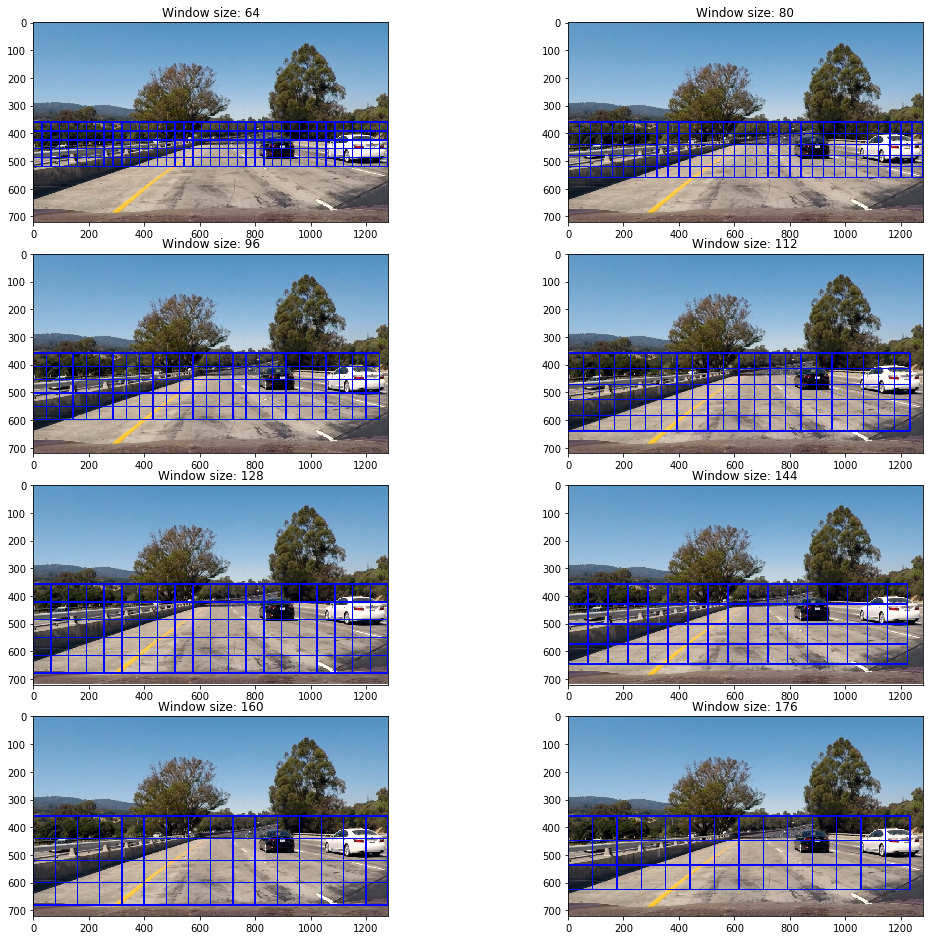

In [90]:
test_img = mpimg.imread('./test_images/test1.jpg')

def search_endpoint(window_size, img_height):
    return int(img_height / 2), int(img_height / 2 + img_height / 2 * window_size / 128)

row,col = 4,2
f, ax = plt.subplots(row, col, figsize=(15,13))
f.tight_layout()

multi_windows = []
for count,size in enumerate(range(64,192,16)):
    start,stop = search_endpoint(size, test_img.shape[0])
    #trim car hood
    if stop > test_img.shape[0] - 35:
        stop = test_img.shape[0] - 35
    window = slide_window(test_img,y_start_stop=[start,stop],xy_window=(size,size),xy_overlap=(0.50,0.50))
    multi_windows.append(window)
    ax.flatten()[count].imshow(draw_boxes(test_img,window,thick=3))
    ax.flatten()[count].set_title('Window size: ' + str(size))

### 2\. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?
Here I demonstrate individual search result for each window size. The false positive result was high at first, so I tried different parameters for my SVM to improve the accuracy. The use of YCbCr color space seems to be a good choice since I get less false positive results on test images. For final video result, the different window-size results should be combined to form the final judgement.

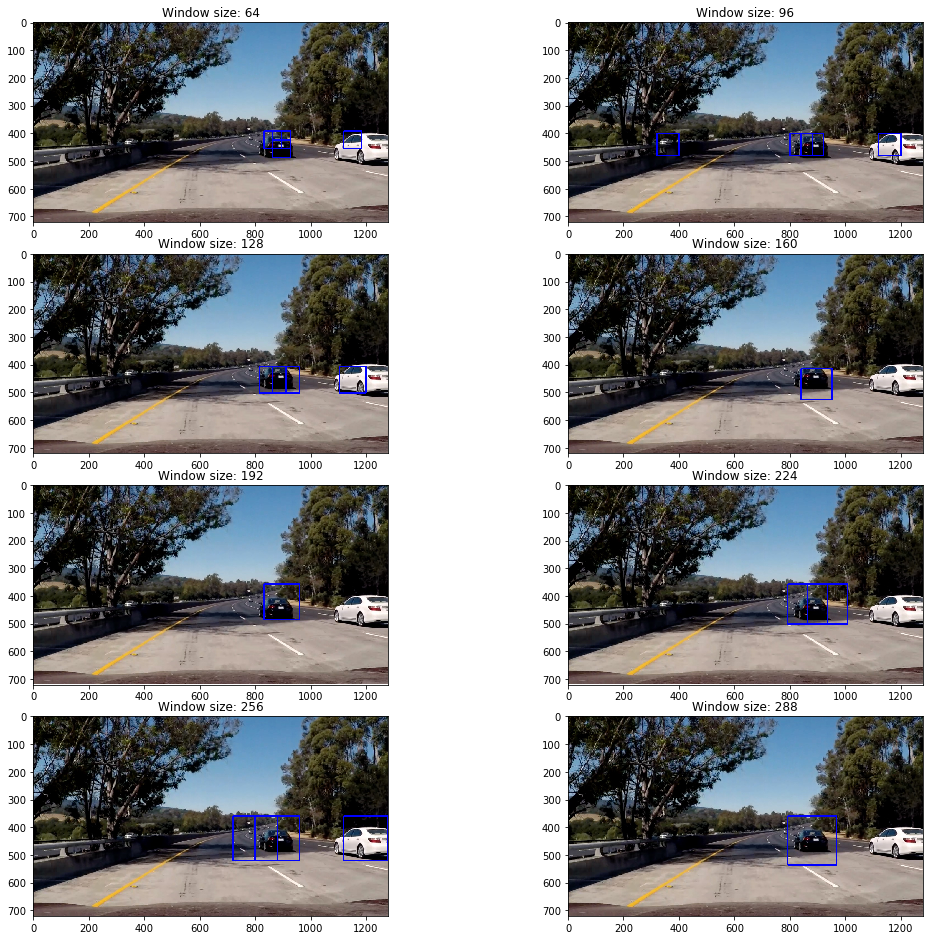

In [124]:
test_img = mpimg.imread('./test_images/test5.jpg')
image = test_img.astype(np.float32)/255

row,col = 4,2
f, ax = plt.subplots(row, col, figsize=(15,13))
f.tight_layout()

hits = []
# draw search result for each window size
for count,windows in enumerate(multi_windows):
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=(spatial,spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)
    draw_image = np.copy(test_img)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)
    ax.flatten()[count].imshow(window_img)
    ax.flatten()[count].set_title('Window size: ' + str(32 * (2 + count)))
    
    hits.extend(hot_windows)


Here I demonstrate the use of heapmap mechanism to filter out false positive results on test image and get the final judgement on where the cars are.

2 cars found.


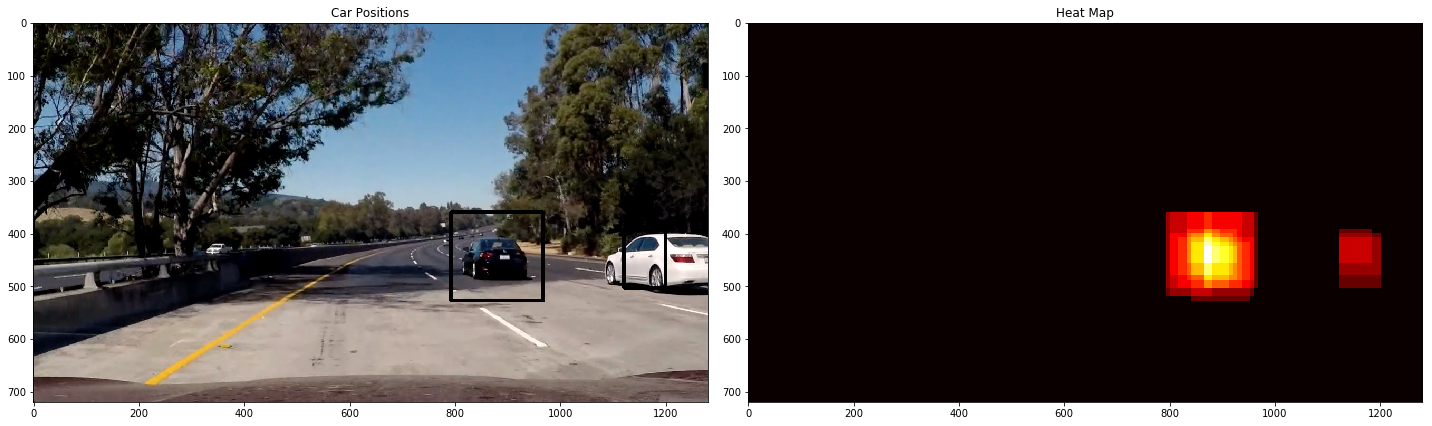

In [125]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hits)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print('{} cars found.'.format(labels[1]) )
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Video Implementation
---
### 1\. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./output_images/project_video.mp4)

In [61]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [138]:
def vehicle_detection_pipeline(img):
    search_img = img.astype(np.float32)/255
    
    hits = []
    for windows in multi_windows:
        hot_windows = search_windows(search_img, windows, svc, X_scaler, color_space=cspace, 
                        spatial_size=(spatial,spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)
        hits.extend(hot_windows)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hits)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [145]:
output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
final_clip = clip1.fl_image(vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time final_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [36:56<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 36min 55s, sys: 1.2 s, total: 36min 56s
Wall time: 36min 57s


### 2\. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.

## Discussion
---
### 1\. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
The video result shows that two car on the right hand side are tracked constantly, but the pipeline failed to detect several frames for the white car. As a result, I export the failed images and adjust the parameters for these images.

1.75756


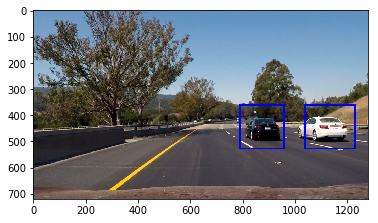

In [144]:
#test_img = mpimg.imread('./output_images/Screenshot from project_video.mp4.png')
test_img = mpimg.imread('./test_images/test6.jpg')
t=time.time()
img = vehicle_detection_pipeline(test_img)
t2=time.time()
print(round(t2-t,5))
plt.imshow(img)